In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
from scipy.optimize import minimize

In [2]:
r_garch = pd.read_csv("r_garch.csv")
r_garch = np.array(r_garch["0"])

In [3]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial 
    LL = g_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h)

    return LL

In [4]:
def optimize_h(data):
    fun = lambda h: -g_i(data[0], h) # function to minimize
    h_init = 1 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

optimize_h(r_garch)

1.412811897635871

In [5]:
M = 2000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.2, 0.15, 0.6] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.015  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

In [6]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = g(Y, data = r_garch, h_initial=h_initial) - g(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)

 ... 1000
 ... 2000
 ... 3000
 ... 4000
 ... 5000


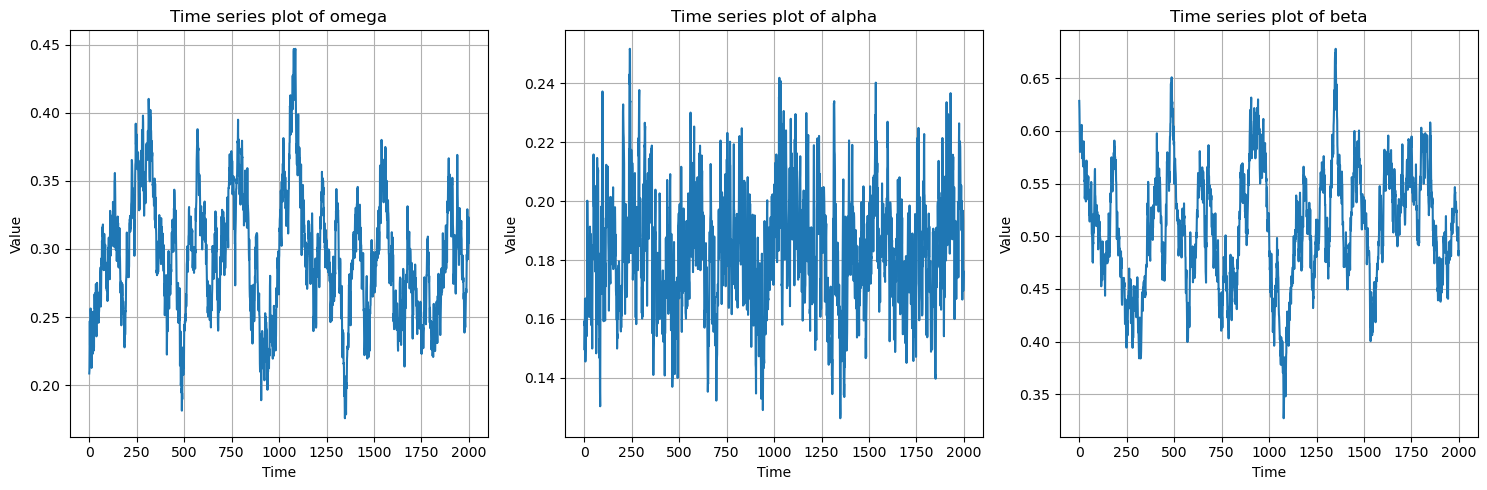

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [8]:
B = 600  # amount of burn-in

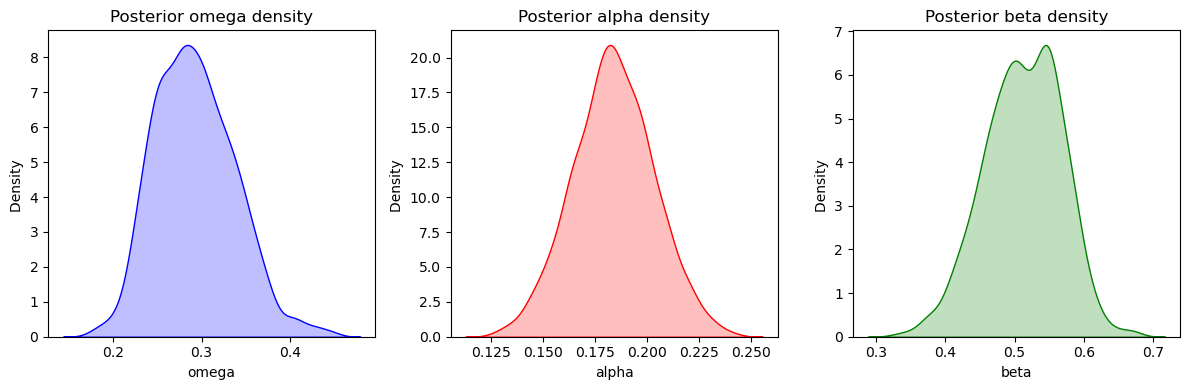

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

In [10]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 2000 iterations, with burn-in 600
acceptance rate = 0.36429872495446264
mean of x1 is about 0.2921457171648419
mean of x2 is about 0.1837358134633942
mean of x3 is about 0.5118755980622707


In [11]:
X_stack = np.vstack([x1list[(B):(len(x1list))], x2list[(B):(len(x2list))], x3list[(B):(len(x3list))]])

In [12]:
X_stack = X_stack.T

In [13]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial 
    LL = g_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h)

    return LL

In [14]:
g = list(map(lambda x: g(x, data=r_garch, h_initial=h_initial), X_stack))

In [15]:
def z1_i(r, h):
    return 0.25/h-0.25*r**2/(h**2) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def z1(x , data, h_initial):
    h = h_initial 
    LL = z1_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += z1_i(data[i],h)

    return LL

In [16]:
gradient1 = list(map(lambda x: z1(x, data=r_garch, h_initial=h_initial), X_stack))

In [17]:
def z2_i(r,h):
    return 0.25*r**2/h-0.25*r**4/(h**2)
def z2(x , data, h_initial):
    h = h_initial
    Z = z2_i(data[0],h)
    
    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z2_i(data[i],h)

    return Z

In [18]:
gradient2 = list(map(lambda x: z2(x, data=r_garch, h_initial=h_initial), X_stack))

In [19]:
def z3_i(r,h):
    return 0.25-0.25*r**2/h
def z3(x , data, h_initial):
    h = h_initial
    Z = z2_i(data[0],h)
    
    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z3_i(data[i],h)

    return Z

In [20]:
gradient3 = list(map(lambda x: z3(x, data=r_garch, h_initial=h_initial), X_stack))

In [21]:
X = np.vstack([gradient1, gradient2,gradient3]).T
X = sm.add_constant(X) # Ajout d'une constante pour ajuster l'ordonnée à l'origine
y = g
model = sm.OLS(y, X).fit(cov_type='HC3') # ajustement du modèle de régression linéaire
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     3039.
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:27:02   Log-Likelihood:                -334.50
No. Observations:                1400   AIC:                             677.0
Df Residuals:                    1396   BIC:                             698.0
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1131.9720      7.895   -143.378      0.0

In [22]:
def f_i(r, h):
    z1 = (0.25/h-0.25*r**2/(h**2))
    z2 = (0.25*r**2/h-0.25*r**4/(h**2))
    z3 = (0.25-0.25*r**2/h)
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) - model.params[0] - model.params[1] * z1 - model.params[2] * z2 - model.params[3] * z3 

def f(x , data, h_initial):
    h = h_initial 
    LL = f_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += f_i(data[i],h)

    return LL

In [23]:
def optimize_f(data):
    fun = lambda h: -f_i(data[0], h) # function to minimize
    h_init = 2 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

optimize_f(r_garch)

2.6234046940701443

In [24]:
M = 5000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.4, 0.3, 0.6] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.001  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

In [25]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = f(Y, data = r_garch, h_initial=h_initial) - f(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)

 ... 1000
 ... 2000
 ... 3000
 ... 4000
 ... 5000


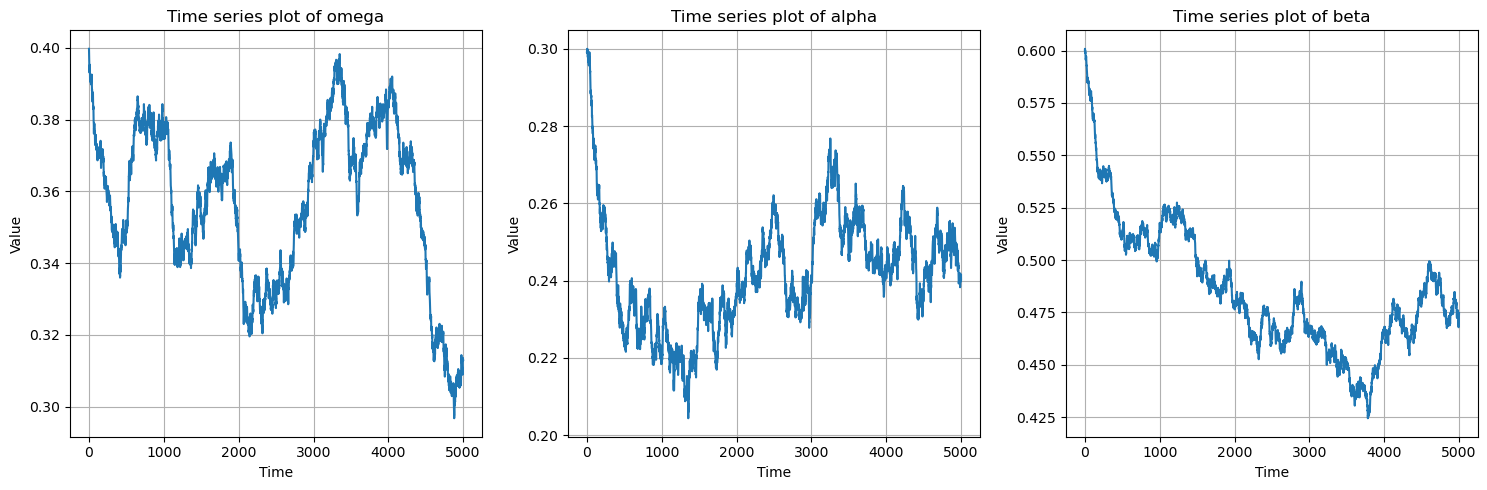

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [27]:
B = 600  # amount of burn-in

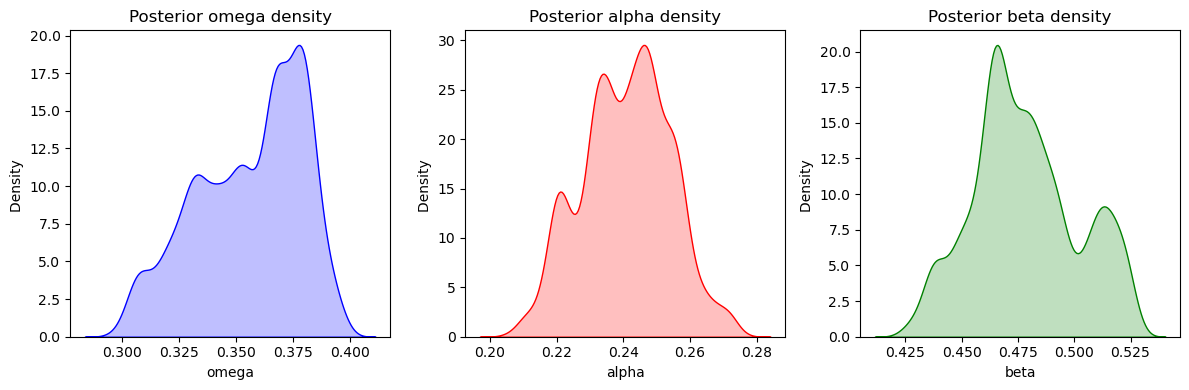

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

In [29]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 5000 iterations, with burn-in 600
acceptance rate = 0.9604302727621975
mean of x1 is about 0.35603963855468257
mean of x2 is about 0.24077699478416145
mean of x3 is about 0.4781778357653624


In [31]:
zvmcmc_results_P1 = pd.DataFrame({'omega': x1list, 'alpha': x2list, 'beta': x3list})
zvmcmc_results_P1.to_csv('zvmcmc_results_P1.csv', index=False)

In [32]:
mcmc_results = pd.read_csv("mcmc_results.csv")

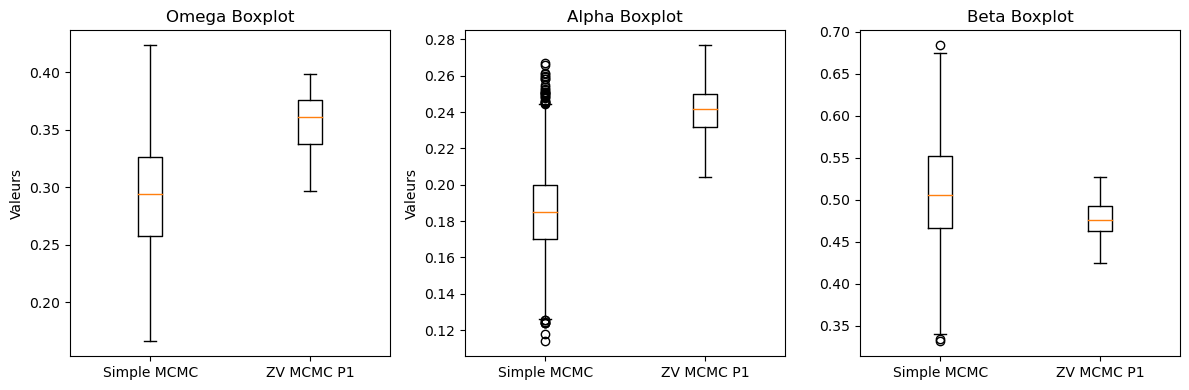

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Omega box-plot
axes[0].boxplot([mcmc_results['omega'][B:], zvmcmc_results_P1['omega'][B:]])
axes[0].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[0].set_ylabel('Valeurs')
axes[0].set_title('Omega Boxplot')

# Alpha box-plot
axes[1].boxplot([mcmc_results['alpha'][B:], zvmcmc_results_P1['alpha'][B:]])
axes[1].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[1].set_ylabel('Valeurs')
axes[1].set_title('Alpha Boxplot')

# Beta box-plot
axes[2].boxplot([mcmc_results['beta'][B:], zvmcmc_results_P1['beta'][B:]])
axes[2].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[2].set_title('Beta Boxplot')

# space between subplots
fig.tight_layout()

# Display
plt.show()